In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-08-12 13:18:41.364634
Simons Foundation, Rusty HPC, worker3171


In [2]:
%cd /mnt/home/zzhang/ceph/jemm
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/jemm


In [3]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

%run ./notebook/navy_utils.py $DATA_VER $PCS_TO_INCL $USE_RE

navy_utils.py data-V7 ['PC0', 'PC6'] True


# Read Data

In [5]:
data = pd.read_table('%s/fluidigm/clinical_fluidigm_CT.txt'%DATA_VER, sep="\t")
data = data[data['Sample_Name']!='Empty']
meta = pd.read_table('%s/fluidigm/clinical_cohort.txt'%DATA_VER)
meta.rename(columns={'Unnamed: 2': 'Sample_Name'}, inplace=True)

In [6]:
data = data.merge(meta, on='Sample_Name')

In [7]:
# add limit of detection as from Joel Brockman

def post_processing(data, lod=24, value_col='CT_Value'):
    data[value_col][data[value_col].isnull()] = -1
    data[value_col][data[value_col] == 999] = -1 # itn_readCtRawDataFromTableFormat where data1_ct[data1_quality == "Fail" & as.numeric(data1_ct) < 999] <- -1

    data[value_col][data[value_col] == -1] = lod # itn_UpdateMissingData where expression_data[expression_data == -1] <- exp$lod[1, 1]

    data[value_col] = lod - data[value_col] # itn_generateLog2EXDataFromOrgData where expression_data <- lod - expression_data
    data[value_col][data[value_col] < 0] = 0 # itn_generateLog2EXDataFromOrgData where expression_data[expression_data < 0] <- 0
    return data


In [8]:
data = post_processing(data)
data.head()

,ID,Sample_Name,Sample_Type,Sample_rConc,FAM_MGB_Name,FAM_MGB_Type,CT_Value,CT_Quality,CT_Call,CT_Threshold,Sample,Well,sid,pid,echo_test_diagnosis,cohort,RNA conc (ng/uL),RIN,Vol (uL)
0,S06-A01,CEPN_33,Unknown,1,ATP6V0B_longP,Test,14.469673,0.904926,Pass,0.004,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
1,S06-A02,CEPN_33,Unknown,1,IGLL5_longP,Test,13.440156,0.728991,Pass,0.004,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
2,S06-A03,CEPN_33,Unknown,1,LILRB2_longP_A3,Test,12.805480,0.778291,Pass,0.009,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
3,S06-A04,CEPN_33,Unknown,1,LST1_longP_A4,Test,15.149832,0.957777,Pass,0.010,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
4,S06-A05,CEPN_33,Unknown,1,PALM2AKAP2_longP,Test,10.041861,0.743432,Pass,0.008,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9


# Match Isoforms

In [9]:
isoform_match = defaultdict(list)
unmatched = []
for x in data['FAM_MGB_Name'].unique():
    if x.endswith('_longP'):
        isoform_match[x.replace('_longP', '')].append(x)
    elif x.endswith('_shortP'):
        isoform_match[x.replace('_shortP', '')].append(x)
    else:
        unmatched.append(x)

unmatched

['LILRB2_longP_A3',
 'LST1_longP_A4',
 'Empty',
 'LILRB2_shortP_B3',
 'LST1_shortP_B4',
 'LILRB2_longP_C3',
 'LST1_longP_C4',
 'PHOSPHO1_longP_C5',
 'LILRB2_shortP_D3',
 'LST1_shortP_D4',
 'PHOSPHO1_shortP_D5',
 'PHOSPHO1_longP_E5',
 'LST1_longP_E4',
 'PHOSPHO1_shortP_F5',
 'LST1_shortP_F4',
 'LST1_longP_G3',
 'HK-ACTB',
 'LST1_shortP_H3']

In [10]:
isoform_match.update(
{
    'LILRB2_A': ['LILRB2_longP_A3', 'LILRB2_shortP_B3'],
    'LST1_A': ['LST1_longP_A4', 'LST1_shortP_B4'],
    'LILRB2_C': ['LILRB2_longP_C3', 'LILRB2_shortP_D3'],
    'LST1_C': ['LST1_longP_C4', 'LST1_shortP_D4'],
    'PHOSPHO1_D': ['PHOSPHO1_longP_C5', 'PHOSPHO1_shortP_D5'],
    'PHOSPHO1_E': ['PHOSPHO1_longP_E5', 'PHOSPHO1_shortP_F5'],
    'LST1_E': ['LST1_longP_E4', 'LST1_shortP_F4'],
    'LST1_G': ['LST1_longP_G3', 'LST1_shortP_H3']
}
)

print(len(isoform_match))
vals = [v2 for v1 in isoform_match.values() for v2 in v1]
[x for x in unmatched if x not in vals]

27


['Empty', 'HK-ACTB']

# Compute pseudo-PSI

Exon usage ratio = log(long/short) = CT_long - CT_short

In [11]:
# alway make longP as the first item
isoform_match = {k:sorted(v) for k,v in isoform_match.items()}
isoform_match

{'ATP6V0B': ['ATP6V0B_longP', 'ATP6V0B_shortP'],
 'IGLL5': ['IGLL5_longP', 'IGLL5_shortP'],
 'PALM2AKAP2': ['PALM2AKAP2_longP', 'PALM2AKAP2_shortP'],
 'RIN2': ['RIN2_longP', 'RIN2_shortP'],
 'TUBA8': ['TUBA8_longP', 'TUBA8_shortP'],
 'EPSTI1': ['EPSTI1_longP', 'EPSTI1_shortP'],
 'IQSEC1': ['IQSEC1_longP', 'IQSEC1_shortP'],
 'RPS3A': ['RPS3A_longP', 'RPS3A_shortP'],
 'U91328.1': ['U91328.1_longP', 'U91328.1_shortP'],
 'SESN3': ['SESN3_longP', 'SESN3_shortP'],
 'LRRK1': ['LRRK1_longP', 'LRRK1_shortP'],
 'KIF22': ['KIF22_longP', 'KIF22_shortP'],
 'GALNS': ['GALNS_longP', 'GALNS_shortP'],
 'ZFYVE26': ['ZFYVE26_longP', 'ZFYVE26_shortP'],
 'SNHG32': ['SNHG32_longP', 'SNHG32_shortP'],
 'RILP': ['RILP_longP', 'RILP_shortP'],
 'MRPS22': ['MRPS22_longP', 'MRPS22_shortP'],
 'KY': ['KY_longP', 'KY_shortP'],
 'HMGN2': ['HMGN2_longP', 'HMGN2_shortP'],
 'LILRB2_A': ['LILRB2_longP_A3', 'LILRB2_shortP_B3'],
 'LST1_A': ['LST1_longP_A4', 'LST1_shortP_B4'],
 'LILRB2_C': ['LILRB2_longP_C3', 'LILRB2_shortP_

In [12]:
def compute_psi_from_ct(sample, df, isoform_match):
    res = {}
    df.index = df['FAM_MGB_Name']
    for evt in isoform_match:
        res[evt] = df.loc[isoform_match[evt][0], 'CT_Value'] - df.loc[isoform_match[evt][1], 'CT_Value']
    res = pd.Series(res, name=sample)
    return res

In [13]:
# compute PSI in log space
psi_df = [compute_psi_from_ct(x[0], x[1], isoform_match) for x in data.groupby('Sample_Name')]

# Make Dfs

In [14]:
annot = meta[['Sample_Name', 'sid', 'echo_test_diagnosis']]
annot.set_index(annot['Sample_Name'], inplace=True)
psi_df = pd.DataFrame(psi_df)
psi_df_ = pd.melt(psi_df, ignore_index=False)
annot_df = annot.join(psi_df)
plot_df = annot.join(psi_df_)

In [15]:
probe_data = data.pivot_table(index='Sample_Name', columns='FAM_MGB_Name', values='CT_Value', aggfunc='mean')
probe_data = annot.join(probe_data)
probe_data = probe_data.loc[:, ~probe_data.columns.isin(['Empty', 'HK-ACTB'])]

In [16]:
#plot_df.head()
plot_df.variable.unique()

array(['ATP6V0B', 'IGLL5', 'PALM2AKAP2', 'RIN2', 'TUBA8', 'EPSTI1',
       'IQSEC1', 'RPS3A', 'U91328.1', 'SESN3', 'LRRK1', 'KIF22', 'GALNS',
       'ZFYVE26', 'SNHG32', 'RILP', 'MRPS22', 'KY', 'HMGN2', 'LILRB2_A',
       'LST1_A', 'LILRB2_C', 'LST1_C', 'PHOSPHO1_D', 'PHOSPHO1_E',
       'LST1_E', 'LST1_G'], dtype=object)

In [17]:
fluidigm_evts = pd.read_table('%s/fluidigm/fluidigm_evts.patch1.fixRI.tsv'%DATA_VER, sep="\t")
fluidigm_genenames = sorted(isoform_match.keys())
fluidigm_evts['genename.f'] = ''
for i in fluidigm_evts.index:
    g = fluidigm_evts.loc[i, 'genename']
    j = [k for k in range(len(fluidigm_genenames)) if fluidigm_genenames[k].startswith(g)]
    if len(j):
        fluidigm_evts.loc[i, 'genename.f'] = fluidigm_genenames.pop(j[0])

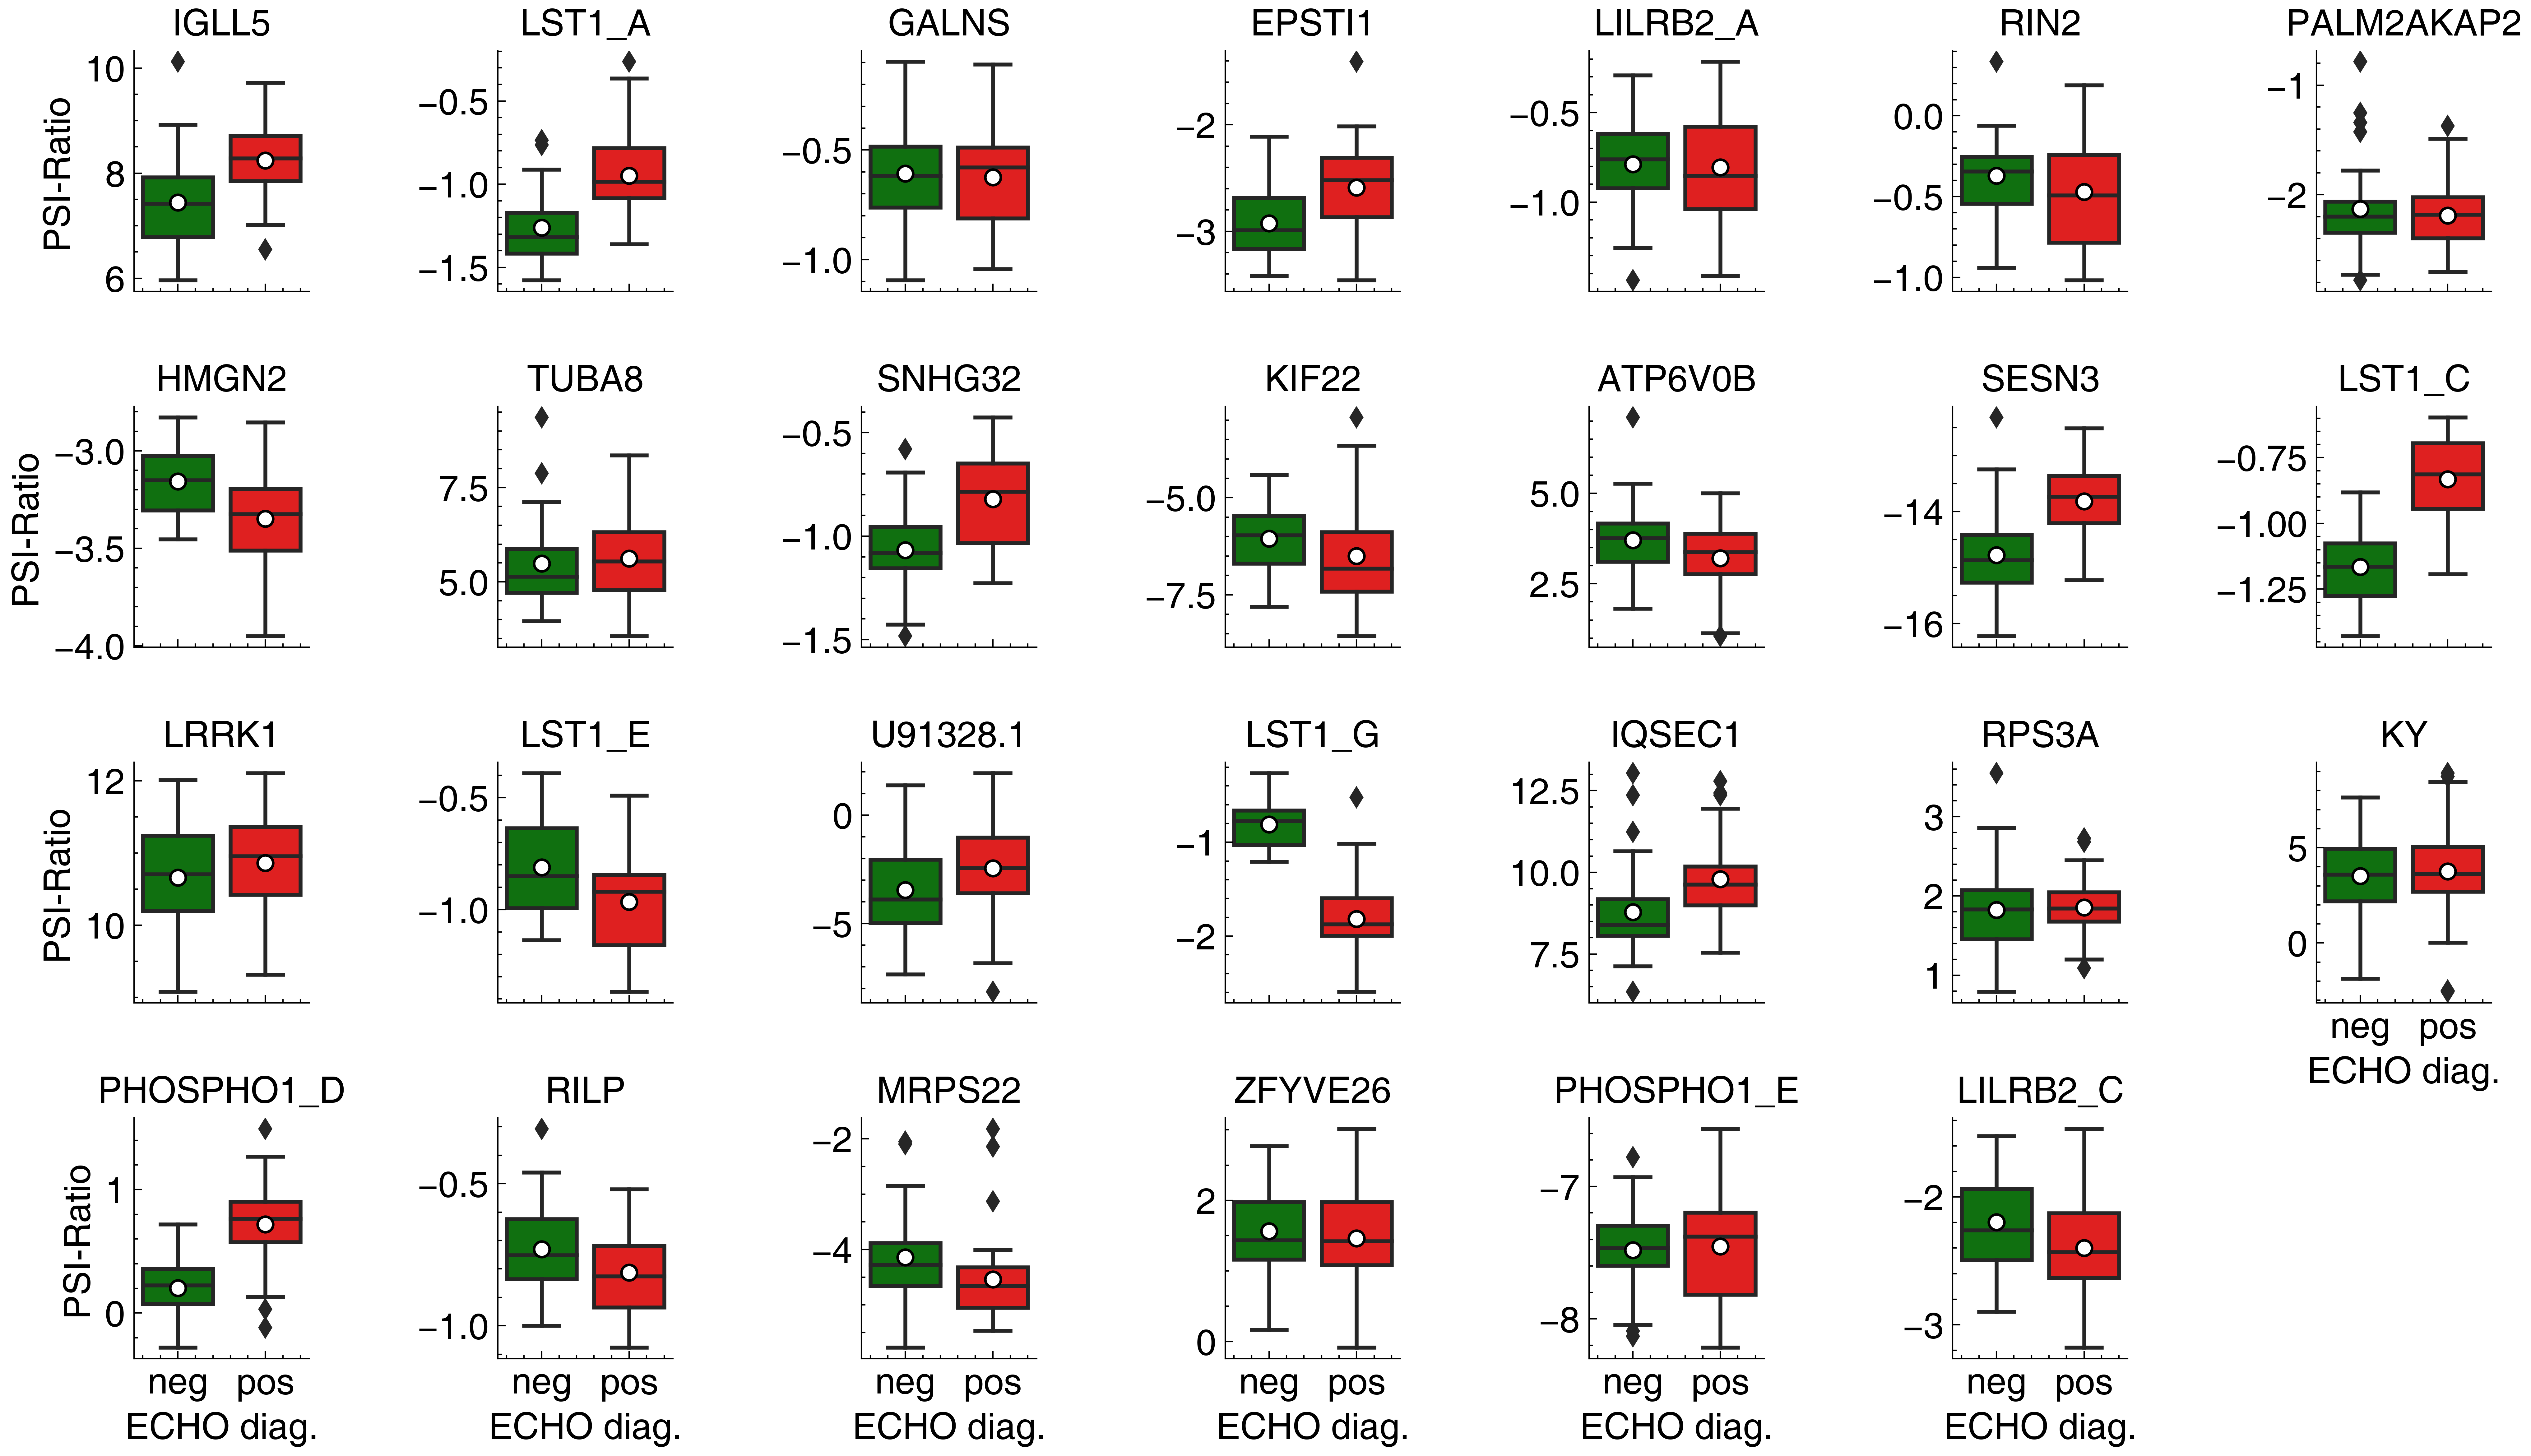

In [18]:
g = sns.FacetGrid(plot_df, col="variable",  col_wrap=7, 
                  sharey=False, 
                  col_order=fluidigm_evts['genename.f'],
                  height=2
                 )
g.map(sns.boxplot, "echo_test_diagnosis", "value", 
      order=['neg', 'pos'], 
      showmeans=True, 
      meanprops={"marker": 'o', "markerfacecolor":"white", "markeredgecolor": "black"},
      palette=['green', 'red'],
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("ECHO diag.", "PSI-Ratio")

# PCA

In [19]:
# does this match the numbers from JB?
probe_data.loc[['CEPN_33', 'CEPN_25', 'CEPN_17']]

,Sample_Name,sid,echo_test_diagnosis,ATP6V0B_longP,ATP6V0B_shortP,EPSTI1_longP,EPSTI1_shortP,GALNS_longP,GALNS_shortP,HMGN2_longP,...,SESN3_longP,SESN3_shortP,SNHG32_longP,SNHG32_shortP,TUBA8_longP,TUBA8_shortP,U91328.1_longP,U91328.1_shortP,ZFYVE26_longP,ZFYVE26_shortP
Sample_Name,,,,,,,,,,,,,,,,,,,,,
CEPN_33,CEPN_33,20_1560-T00,neg,14.469673,7.369160,10.693776,13.252325,9.280181,9.875989,12.035879,...,0.0,14.900692,11.391299,12.452378,9.357949,0.000000,0.000000,6.439923,10.780210,8.078806
CEPN_25,CEPN_25,20_3255-T60,pos,14.970492,12.727316,12.994901,16.018115,9.811017,10.389776,12.143847,...,0.0,14.974102,12.064402,13.222873,11.162461,5.785573,6.087234,7.290635,10.215021,8.925059
CEPN_17,CEPN_17,20_1321-T39,pos,15.171064,11.972085,13.566625,16.481273,10.437637,11.000792,13.096213,...,0.0,13.493356,12.314714,13.541115,10.482342,5.931344,5.244567,9.078411,11.061371,8.902060


In [20]:
%%R
library(tidyverse)

theme_set(theme_bw(base_size = 12))
options(repr.plot.width=9, repr.plot.height=9)

myTheme = ggplot2::theme(
                legend.text = ggplot2::element_text(size = 13),
                plot.title = ggplot2::element_text(size=13, face="bold"),
                axis.title.y = ggplot2::element_text(size=13),
                axis.title.x = ggplot2::element_text(size=13),
                axis.text.y = ggplot2::element_text(size=13),
                axis.text.x = ggplot2::element_text(size=13),
                legend.background = ggplot2::element_rect(fill = "transparent", colour = "transparent"))

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



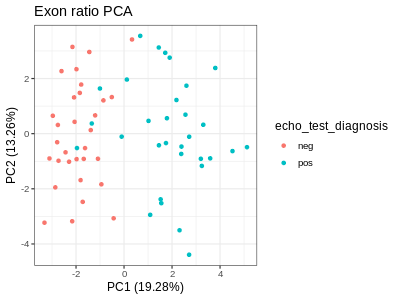

In [21]:
%%R -i annot_df -w 400 -h 300
plot_pca = function(df, start=4, end=30, do_scale=TRUE) {
pca_mat = df[start:end]
pca_mat = pca_mat[, which(apply(pca_mat, 2, var) != 0)]
pca_mat = scale(pca_mat, scale=do_scale)
pca = prcomp(pca_mat)
vars_transformed = apply(pca$x, 2, var)
vars_per_pc = vars_transformed/sum(vars_transformed)
df = cbind.data.frame(df, pca$x)

i = 1
j = 2
g = ggplot(df, aes(x=PC1, y=PC2, color=echo_test_diagnosis)) +
    geom_point() + 
    xlab(paste0('PC',i,' (',round(vars_per_pc[i]*100,2),'%)')) + 
    ylab(paste0('PC',j,' (',round(vars_per_pc[j]*100,2),'%)'))
list(g=g, df=df, pca=pca)
}
res = plot_pca(annot_df, start=4, end=30)
res$g + ggtitle('Exon ratio PCA')

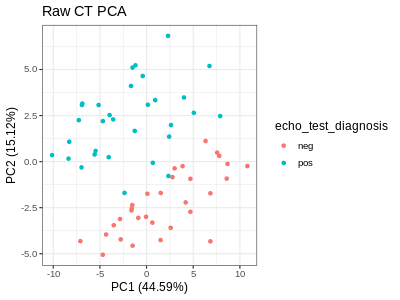

In [22]:
%%R -i probe_data -w 400 -h 300
res = plot_pca(probe_data, start=4, end=4+53, do_scale=F) 
res$g + ggtitle('Raw CT PCA')

In [23]:
%%R

print(sum(res$pca$rotation[, c('PC1')]>0), )
print(sum(res$pca$rotation[, c('PC2')]>0), )
print(dim(res$pca$rotation))

res$pca$rotation[, c('PC1', 'PC2')]


[1] 1
[1] 15
[1] 52 52
                           PC1           PC2
ATP6V0B_longP      -0.11651557 -0.1478409615
ATP6V0B_shortP     -0.14717836 -0.1062347082
EPSTI1_longP       -0.27621199  0.4249085904
EPSTI1_shortP      -0.25101384  0.3608564309
GALNS_longP        -0.12101189 -0.0481189543
GALNS_shortP       -0.11851176 -0.0529987972
HMGN2_longP        -0.12396360 -0.0496688075
HMGN2_shortP       -0.12000836 -0.0103545704
IGLL5_longP        -0.22176369  0.2150768930
IGLL5_shortP       -0.16997969  0.1579021542
IQSEC1_longP       -0.11989181 -0.0647494497
IQSEC1_shortP      -0.12552888 -0.3518668398
KIF22_longP         0.01700821  0.0738028157
KIF22_shortP       -0.15392295  0.0202195798
KY_longP           -0.24559745  0.1165842051
KY_shortP          -0.10879032  0.0470047987
LILRB2_longP_A3    -0.13884325 -0.0575877092
LILRB2_longP_C3    -0.10155008 -0.1003585896
LILRB2_shortP_B3   -0.12130856 -0.0401205806
LILRB2_shortP_D3   -0.11870682 -0.0561443028
LRRK1_longP        -0.12409675 -

In [24]:
print("FINISH:", datetime.now())

FINISH: 2021-08-12 13:19:53.909881
